# RNN

The following code reports the building and experimentation of a small variety of RNN's, mostly LSTM based architectures, that our group set out to construct to tackle the urbandsound8k classification task.
Each code cell is documented with its respective functionality in the markdown cell above it.

In [3]:
# libraries

import tensorflow as tf
from tensorflow import keras
from keras import layers, metrics
import numpy as np
import pickle
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

The files opened in the code below are resultant of the feacture extraction performed in the respective notebook. To run it you must extract the features into files in the already mentioned notebook.

As input for our recurrent models we chose to use the MFCC's since they translate time-series over the Cepstrum Coefficient values which are appropriate RNN inputs.

In [4]:
file_name = "sets/labels_v2"
file_object = open(file_name,'rb')  
labels = pickle.load(file_object) 
file_name = "sets/mfcc_data_v2"
file_object = open(file_name,'rb')  
mfcc = pickle.load(file_object) 
file_name = "sets/fold_pointers_v2"
file_object = open(file_name,'rb')  
fold_pointer = pickle.load(file_object) 
file_name = "sets/spec_data_shared"
file_object = open(file_name,'rb')
spectrogram = pickle.load(file_object)

Shape of MFCC array to be given as input to RNN.

In [5]:
shapers=(mfcc.shape[1],mfcc.shape[2])
print(shapers)
#labels[0]

(40, 321)


Dataset splitting into folds. Details on how this is done are found in the feature extraction notebook.

In [6]:
listmfcc=[]
listlabels=[]
c=0
listspectrogram=[]
for i in range(10):
    j=fold_pointer[i+1]-1
    templabels=[]
    tempmfcc=[]
    while(c<j):
        tempmfcc.append(mfcc[c])
        templabels.append(labels[c])
        c+=1
    #listspectrogram.append(np.array(spectrogram[i]))
    listmfcc.append(np.array(tempmfcc))
    listlabels.append(np.array(templabels))

Below are some utility functions regarding the training procedure as well as the main training pipeline.
The histories and scores of the passed model will be stored for further use.

In [14]:
checkpoint_filepath = 'sets/checkpoint'
metric='sparse_categorical_accuracy'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=metric,
    mode='max',
    save_best_only=True,
    verbose=0)

def crossvalidation_10fold(model_checkpoint_callback,model,listmfcc,listlabels,epocas,nome,bs=32):
    mean_acc=0
    #reinitialize(model)
    for k in range(10):
            model.load_weights('sets/.h5')
            #print("K = ",k)
            for t in range(10):
                if (t!=k):
                    if(k==0):
                        Xtrain=listmfcc[1]
                        Ytrain=listlabels[1]
                        continue
                    if (t==0):
                        Xtrain=listmfcc[0]
                        Ytrain=listlabels[0]
                    np.concatenate((Xtrain,listmfcc[t]))
                    np.concatenate((Ytrain,listlabels[t]))
                    continue
                Xtest=np.array(listmfcc[k])
                Ytest=np.array(listlabels[k])
            history=model.fit(Xtrain,Ytrain,epochs=epocas,batch_size=bs,callbacks=[model_checkpoint_callback],validation_data=(Xtest,Ytest))    
            scores = model.evaluate(Xtest,Ytest,verbose=0)
            print(f"Test accuracy {k} fold: {scores[1]}  TestLoss: {scores[0]}")
            mean_acc+=scores[1]/10
            with open('histories/'+nome+'_history'+'_fold'+str(k+1), 'wb') as file:
                model_history= History_trained_model(history.history, history.epoch, history.params)
                pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)
            with open('scores/'+nome+'_score'+'_fold'+str(k+1),'wb') as file:
                pickle.dump(scores,file,pickle.HIGHEST_PROTOCOL)
    return history,scores,mean_acc


def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params
            

The standard LSTM model approach follows. We use 40 LSTM units given the fact we're dealing with 40 MFCC's, so matching the nº of features to the number of units, as expected.
The dropout rate is selected to 0.2, sugestion by Yang, et Al(2019).
Softmax and Hyperbolic Tangent Layers are standard procedure in RNN's.

In [35]:
bilstm=keras.Sequential([layers.Input(shape=shapers)])
bilstm.add(layers.LSTM(40,dropout=0.2))    # dropout suggested by Yang et Al, 40 units for n_mfccs 
bilstm.add(layers.Dense(10))               # number of labels
bilstm.add(layers.Softmax())
bilstm.add(layers.Activation(keras.activations.tanh))    
bilstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 40)                57920     
                                                                 
 dense_8 (Dense)             (None, 10)                410       
                                                                 
 softmax_6 (Softmax)         (None, 10)                0         
                                                                 
 activation_6 (Activation)   (None, 10)                0         
                                                                 
Total params: 58,330
Trainable params: 58,330
Non-trainable params: 0
_________________________________________________________________


Firstly we're doing a brief hyperparameter assessment in order to choose what Loss and Optimizer to stick with when building new models, just for referrence.
 A thourough and definitive hyperparameter tuning will be held in the final model assessment and evaluation.

In [36]:
epocas=30
for l in ["KLDivergence","SparseCategoricalCrossentropy"]:
    for o in ["adam","sgd"]: #adam or rmsprop?
        bilstm.compile(optimizer=o,loss=l,metrics=[metrics.SparseCategoricalAccuracy()])
        bilstm.save_weights('sets/.h5')
        print(f"Loss: {l} Optimizer: {o}")
        history,scores,mean_acc=crossvalidation_10fold(model_checkpoint_callback,bilstm,listmfcc,listlabels,epocas,'sdlstm')
        print(f"Mean acc: {mean_acc}")

Loss: KLDivergence Optimizer: adam
Test accuracy 0 fold: 0.10194730758666992  TestLoss: 20.42441177368164
Test accuracy 1 fold: 0.09684684872627258  TestLoss: 20.46504783630371
Test accuracy 2 fold: 0.12324324250221252  TestLoss: 20.567270278930664
Test accuracy 3 fold: 0.11818181723356247  TestLoss: 20.73112678527832
Test accuracy 4 fold: 0.10042735189199448  TestLoss: 20.596141815185547
Test accuracy 5 fold: 0.12636694312095642  TestLoss: 20.25790023803711
Test accuracy 6 fold: 0.12291169166564941  TestLoss: 20.307964324951172
Test accuracy 7 fold: 0.08010012656450272  TestLoss: 20.173641204833984
Test accuracy 8 fold: 0.08700980246067047  TestLoss: 20.233579635620117
Test accuracy 9 fold: 0.08721625059843063  TestLoss: 20.304584503173828
Mean acc: 0.10442513823509217
Loss: KLDivergence Optimizer: sgd
Test accuracy 0 fold: 0.1111111119389534  TestLoss: 20.417808532714844
Test accuracy 1 fold: 0.10472972691059113  TestLoss: 20.462644577026367
Test accuracy 2 fold: 0.12216216325759888 

Comparing the results obtained by the different hyperparameters choice, we're sticking with the Sparse Categorical Crossentropy as the Loss and ADAM  for Optimizer, because of its stability. 

Adding L2 normalization to the Fully Connected layers and making the LSTM cells Bidirectional, we shall train the model again in order to compare results.

We see how setting stateful=True could yield better results, since a given window in one example could give important information for the subsequent examples. In order to do that we would've need to specify a batch size, however. Since the folds have different sizes and this feature only being discovered in a late stage of the project, due to all the constraints associated with trying this approach in this stage we shall leave this finding for further development, not incorporating in this project's instance.

It is also worth mentioning that we tried to calculate the AUC-ROC for each class which didn't work for some output related reason. Keras.Metrics is suited for such and the commented tail of the compile command shows the syntax to carry such operation.

In [43]:
bilstm=keras.Sequential([layers.Input(shape=shapers)])
bilstm.add(layers.Bidirectional(layers.LSTM(40,dropout=0.2)))     # dropout suggested by Yang et Al, 40 for n_mfcc's, pensar em bilLSTM
bilstm.add(layers.Dense(10,kernel_regularizer='l2'))               # number of labels
bilstm.add(layers.Softmax())
bilstm.add(layers.Activation(keras.activations.tanh))    # why not sigmoid?!
bilstm.summary()

epocas=50
bilstm.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=[metrics.SparseCategoricalAccuracy()])#,metrics.AUC(multi_label=True,num_labels=10),])
bilstm.save_weights('sets/.h5')
history,scores,mean_acc=crossvalidation_10fold(model_checkpoint_callback,bilstm,listmfcc,listlabels,epocas,'bilstm')
print(f"Mean acc: {mean_acc}")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 80)               115840    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 10)                810       
                                                                 
 softmax_7 (Softmax)         (None, 10)                0         
                                                                 
 activation_7 (Activation)   (None, 10)                0         
                                                                 
Total params: 116,650
Trainable params: 116,650
Non-trainable params: 0
_________________________________________________________________
Test accuracy 0 fold: 0.2164948433637619  TestLoss: 2.668415069580078
Test accuracy 1 fold: 0.18468467891216278  T

These changes didn't make much for the model's test accuracy as a trade off for twice the parameter space. They would, howeever, be later reutilized in some subsequent architectures.

The next architecture proposed is based on TimeDistributed Layers. These are Fully Connected Layers stemming from two parallel LSTM cell sequences.

In [15]:
input=layers.Input(shape=shapers)
lc1=layers.LSTM(40,dropout=0.2,return_sequences=True)(input)  
lc2=layers.LSTM(40,dropout=0.2,return_sequences=True)(input)                        
concatenated=layers.concatenate([lc1,lc2])
td=layers.TimeDistributed(layers.Dense(80))(concatenated)
f=layers.Flatten()(td)            # number of labels
dense=layers.Dense(10,kernel_regularizer='l2')(f)
sft=layers.Softmax()(dense)
th=layers.Activation(keras.activations.tanh)(sft)    # why not sigmoid?!
lstm=keras.Model(inputs=input,outputs=th)
lstm.summary()

epocas=50
lstm.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=[metrics.SparseCategoricalAccuracy()])#,metrics.AUC(multi_label=True,num_labels=10)])
lstm.save_weights('sets/.h5')
history,scores,mean_acc=crossvalidation_10fold(model_checkpoint_callback,lstm,listmfcc,listlabels,epocas,'tdlstm')
print(f"Mean acc: {mean_acc}")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 321)]    0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 40, 40)       57920       ['input_2[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 40, 40)       57920       ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 40, 80)       0           ['lstm_1[0][0]',                 
                                                                  'lstm_2[0][0]']             

As we've seen this change yielded an significant increase in accuracy comparing to the previous and first proposals, scaling the parameter count with a factor of 3/2 (only!) and 3 respectively.

Let us now try to implement the previous setting with two Bidirectional Loops consisting in twice the amount of LSTM Units, basically adding a cell equal to the already existing one to feed backwards. These will have their input merged and the remaining Layer sequence is the same as the previous proposal. 

In [44]:
input=layers.Input(shape=shapers)
lc11=layers.LSTM(40,dropout=0.2,return_sequences=True)
lc12=layers.LSTM(40,dropout=0.2,return_sequences=True,go_backwards=True)
lc21=layers.LSTM(40,dropout=0.2,return_sequences=True)
lc22=layers.LSTM(40,dropout=0.2,return_sequences=True,go_backwards=True)
b1=layers.Bidirectional(lc11, backward_layer=lc12)(input)  
b2=layers.Bidirectional(lc21, backward_layer=lc22)(input)                            
concatenated=layers.concatenate([b1,b2])
td=layers.TimeDistributed(layers.Dense(80))(concatenated)
f=layers.Flatten()(td)            # number of labels
dense=layers.Dense(10,kernel_regularizer='l2')(f)
sft=layers.Softmax()(dense)
th=layers.Activation(keras.activations.tanh)(sft)    # why not sigmoid?!
lstm=keras.Model(inputs=input,outputs=th)
lstm.summary()

epocas=50
lstm.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=[metrics.SparseCategoricalAccuracy()])
lstm.save_weights('sets/.h5')
history,scores,mean_acc=crossvalidation_10fold(model_checkpoint_callback,lstm,listmfcc,listlabels,epocas,'btdlsm')
print(f"Mean acc: {mean_acc}")


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 40, 321)]    0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 40, 80)      115840      ['input_10[0][0]']               
 )                                                                                                
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 40, 80)      115840      ['input_10[0][0]']               
 )                                                                                                
                                                                                            

We can now observe that the results didn't improve in terms of test accuracy.

For our last experiment, we tried to mimmick an Attention Mechanism in a very ad-hoc implementation to see what results it might yield.

In [30]:
input=layers.Input(shape=shapers)
lc1=layers.LSTM(40,dropout=0.2,return_sequences=True)(input)  
lc2=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc1)
lc3=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc2)
lc4=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc3)  
lc5=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc4)
lc6=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc5)
lc7=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc6)  
lc8=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc7)
lc9=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc8)
lc10=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc9)  
add1=layers.Add()([lc1,lc10])
add2=layers.Add()([lc2,lc10])
add3=layers.Add()([lc3,lc10])
add4=layers.Add()([lc4,lc10])
add5=layers.Add()([lc5,lc10])
add6=layers.Add()([lc6,lc10])
add7=layers.Add()([lc7,lc10])
add8=layers.Add()([lc8,lc10])
add9=layers.Add()([lc9,lc10])
#conc=layers.Concatenate()([add1,add2,add3,add4,add5,add6,add7,add8,add9,lc10])
sft=layers.Softmax()([add1,add2,add3,add4,add5,add6,add7,add8,add9,lc10])
m1=layers.Multiply()([lc1,sft[0]])
m2=layers.Multiply()([lc2,sft[1]])
m3=layers.Multiply()([lc3,sft[2]])
m4=layers.Multiply()([lc4,sft[3]])
m5=layers.Multiply()([lc5,sft[4]])
m6=layers.Multiply()([lc6,sft[5]])
m7=layers.Multiply()([lc7,sft[6]])
m8=layers.Multiply()([lc8,sft[7]])
m9=layers.Multiply()([lc9,sft[8]])
m10=layers.Multiply()([lc10,sft[9]])
conc=layers.Concatenate()([m1,m2,m3,m4,m5,m6,m7,m8,m9,m10])
flt=layers.Flatten('channels_first')(conc)
dense=layers.Dense(10,kernel_regularizer='l2')(flt)
sft=layers.Softmax()(dense)
th=layers.Activation(keras.activations.tanh)(sft)    
lstm=keras.Model(inputs=input,outputs=th)
lstm.summary()

epocas=50
lstm.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=[metrics.SparseCategoricalAccuracy()])#,metrics.AUC(),metrics.Precision(),metrics.Recall()])
lstm.save_weights('sets/.h5')
history,scores,mean_acc=crossvalidation_10fold(model_checkpoint_callback,lstm,listmfcc,listlabels,epocas,'amlstm')
print(f"Mean acc: {mean_acc}")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 321)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 40, 40)       57920       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 40, 40)       12960       ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  (None, 40, 40)       12960       ['lstm_1[0][0]']                 
                                                                                              

The model results weren't better than the already implemented architectures plus an associated cost of twice the trainable parameters. Nevertheless it was an interesting exercise and deeper analysis could hold interesting showings regarding the network's behaviour (or not).

# RNN Results

### General Assessment

In the following code cells we calculate the mean accuracy and standard deviation for each model in the 10-fold crossvalidation.

In [24]:
import math
import pickle
def std_dev(scores):
    mean=0
    for i in range(10):
        mean+=scores[i][1]
    mean/=10
    min_diff=float('inf')
    min_diffi=0
    sum=0
    for i in range(10):
        diff=(mean-scores[i][1])**2
        sum+=diff
        if diff<min_diff:
            min_diff=diff
            min_diffi=i
    s=math.sqrt(sum/9)
    return s,min_diffi,mean

In [25]:
historiesd=[]
scoresd=[]
find=[]
print('================================================================================')
print('Model   |     Mean Accuracy          |    Std Deviation')
print('--------------------------------------------------------------------------------')
for name in ['bilstm','tdlstm','btdlsm','amlstm']:
    scores=[]
    histories=[]
    for i in range(1, 11):
        with open('histories/'+name+'_history'+'_fold' + str(i), 'rb') as file:
            history=pickle.load(file)
            histories.append(history)
        with open('scores/'+name+'_score'+'_fold'+str(i),'rb') as files:
            score=pickle.load(files)
            scores.append(score)
    op=std_dev(scores)
    find.append(op[1])
    scoresd.append(scores)
    historiesd.append(scores)
    print(name+"  |   "+str(op[2])+"      |     "+str(op[0]))
    print('--------------------------------------------------------------------------------')
print('================================================================================')
    


Model   |     Mean Accuracy          |    Std Deviation
--------------------------------------------------------------------------------
bilstm  |   0.20861842781305312      |     0.02862541465313222
--------------------------------------------------------------------------------
tdlstm  |   0.34755243062973024      |     0.04878262255597305
--------------------------------------------------------------------------------
btdlsm  |   0.34453270137310027      |     0.05025503602116361
--------------------------------------------------------------------------------
amlstm  |   0.3154764652252197      |     0.03516057527082268
--------------------------------------------------------------------------------


The table above shows the general results for each model. We shall now assess each model's training behaviour in the fold which fits closer with the mean values.

The next plots are the train/test loss comparison over epoch for the trained models.

### Bidirectional LSTM

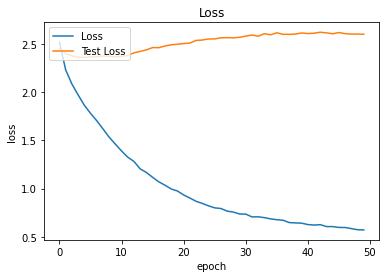

In [19]:
import matplotlib.pyplot as plt
name='bilstm'
with open('histories/'+name+'_history'+'_fold' + str(find[0]+1), 'rb') as file:
    history=pickle.load(file)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss','Test Loss'],loc='upper left')
plt.show()

By looking at this graph we can conclude that the model is overfitting after the 5th epoch and further training without any alterations or parameter regularization would futile. This result is given by the distance between the test/training loss curves as the train loss decreases and the test loss increases.

### Time Distributed LSTM

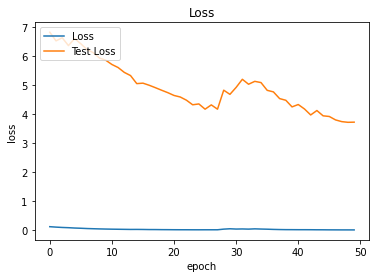

In [29]:
import matplotlib.pyplot as plt
name='tdlstm'
with open('histories/'+name+'_history'+'_fold' + str(find[1]+1), 'rb') as file:
    history=pickle.load(file)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss','Test Loss'],loc='upper left')
plt.show()

We can conclude from the results above that further training could yield better results. We'll get to this topic later.

### Time Distributed BiLSTM

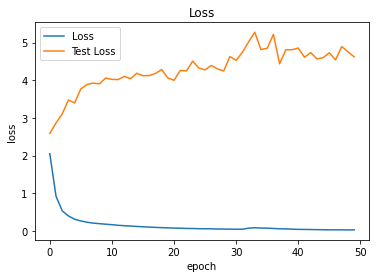

In [21]:
import matplotlib.pyplot as plt
name='btdlsm'
with open('histories/'+name+'_history'+'_fold' + str(find[2]+1), 'rb') as file:
    history=pickle.load(file)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss','Test Loss'],loc='upper left')
plt.show()

This curve shows the overfitting nature combined with the fold data distribution in an increasing mismatch of training and test performance.

### Attention Module LSTM

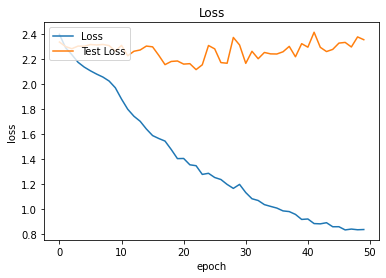

In [32]:
import matplotlib.pyplot as plt
name='amlstm'
with open('histories/'+name+'_history'+'_fold' + str(find[3]+1), 'rb') as file:
    history=pickle.load(file)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss','Test Loss'],loc='upper left')
plt.show()

The erratic nature of the Test Loss curve doesn't give away much information. Maybe training with more epochs wouldn't get better results at all and an early stopping with a low patience value would suit best this model.

### One Last Take

Given the margin for improvement shown in the Time Distributed LSTM training graph we shall try one last training and hyperparameter tuning with more epochs to see if it actually improves.

Edit: after a first attempt to tune the hyperparameters, we've decided to drop the ADAM parameter assessment since it has already been somewhat evaluated and only try to vary the batch size on the ADAMAX optimizer. This is due to the excessive comptuational power and time required for such a test. We would have set the patience to 7, the reason for such value is written in the comments, but to assess the ADAMAX optimizer without unnecessary operations we set the value to 3.

Second Edit: after the second attempt, we came to the conclusion that this even simplified assessment is not feasable in the current stage of the project. This is due to the very erratic nature of the test loss curve which can't be conteracted with Early Stopping. We believe this is caused by the high sensibility of the model to noise, which makes the test loss fluctuate and stay under the patience threshold and so not early stopping, even if it oughted to stop.

The history files of the attempts were stored but the decision came mainly from looking at the on time outputs of the model's behaviour. For the ADAMAX independently of batch size we observed a peak of training accuracy (1.0000) and subsequent plateau around epoch 40 which lasted for the remaining epochs not achieving better test results meanwhile. We ran a last test on the TD-LSTM with batch size 32 and ADAM optimizer during 100 epochs to confirm the hypothesis proposed in the previous evaluation.

In [21]:
input=layers.Input(shape=shapers)
lc1=layers.LSTM(40,dropout=0.2,return_sequences=True)(input)  
lc2=layers.LSTM(40,dropout=0.2,return_sequences=True)(input)                        
concatenated=layers.concatenate([lc1,lc2])
td=layers.TimeDistributed(layers.Dense(80))(concatenated)
f=layers.Flatten()(td)            # number of labels
dense=layers.Dense(10,kernel_regularizer='l2')(f)
sft=layers.Softmax()(dense)
th=layers.Activation(keras.activations.tanh)(sft)   
lstm=keras.Model(inputs=input,outputs=th)


callback=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=7)  # we shall apply early stopping with a high patience level due to the second curve in the graph
                                                                         # that we wish not to stop in the middle of, since the improvement happens after it
epocas=100
for b  in [32]:
    for o in ['adam']:
        lstm.compile(optimizer=o,loss='SparseCategoricalCrossentropy',metrics=[metrics.SparseCategoricalAccuracy()])#,metrics.AUC(multi_label=True,num_labels=10)])
        lstm.save_weights('sets/.h5')
        history,scores,mean_acc=crossvalidation_10fold(callback,lstm,listmfcc,listlabels,epocas,f'ltd/ltdlstm_b{b}_o{o}',b)
        print(f"Mean acc: {mean_acc}")

Epoch 1/100
28/28 [==============================] - 9s 133ms/step - loss: 2.1665 - sparse_categorical_accuracy: 0.3108 - val_loss: 2.5302 - val_sparse_categorical_accuracy: 0.1959
Epoch 2/100
28/28 [==============================] - 3s 94ms/step - loss: 1.1073 - sparse_categorical_accuracy: 0.7387 - val_loss: 2.6206 - val_sparse_categorical_accuracy: 0.2955
Epoch 3/100
28/28 [==============================] - 3s 94ms/step - loss: 0.6777 - sparse_categorical_accuracy: 0.8739 - val_loss: 2.9161 - val_sparse_categorical_accuracy: 0.3036
Epoch 4/100
28/28 [==============================] - 3s 93ms/step - loss: 0.4886 - sparse_categorical_accuracy: 0.9493 - val_loss: 3.0382 - val_sparse_categorical_accuracy: 0.3013
Epoch 5/100
28/28 [==============================] - 2s 88ms/step - loss: 0.3870 - sparse_categorical_accuracy: 0.9764 - val_loss: 3.1528 - val_sparse_categorical_accuracy: 0.3253
Epoch 6/100
28/28 [==============================] - 3s 94ms/step - loss: 0.3245 - sparse_categoric

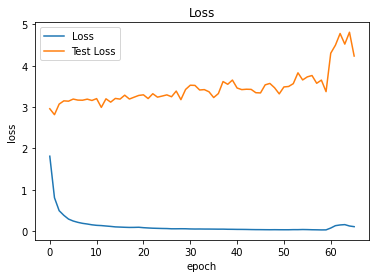

In [42]:
import matplotlib.pyplot as plt
name='ltdlstm'
with open('histories/ltd/'+name+'_b32_oadam_history'+'_fold' + str(10), 'rb') as file:
    history=pickle.load(file)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss','Test Loss'],loc='upper left')
plt.show()

Maybe due to the stochastic nature of the module the training behaviour did not match the expected of the previous iteration and no conclusions could be taken from such.

# Conclusions

The major conclusion that we can get from this project is that something didn't work quite as expected in terms of classification performance. Comparing with other researchers results and even with the general domain knowledge in the topic we would expect the RNN to have a significantly better performance in this task. Even with a very simple architecutre results should range from 60+ to 90+ percent of accuracy throughout the various folds (2).  

The two main issues concerning our Recurrent Models' performance are certainly their tendency to overfit and noise sensibility. We understand that more could be done to solve these issues and the window is open for further development.

It is also worth mentioning that the values given are referrent to the last epoch of each episode and the true best values are not stored but they're not far from the results shown. 

Since the conclusions relating to each particular model have been annotated in their respective comment cells we have nothing else to add to this epilogue except for one final note regarding the enitre procedure. Given the Deep nature of the models, the computational power and time needed to train and experiment were a huge bottleneck to the development of the architectures and their evaluation. For the RNN approach in particular we could perhaps take advantage of a deeper solution but the same wouldn't be feasable to a certain extent and wouldn't be compatible with experimentation.

# References

1. "Urban Sound Source Classification and Comparison" - Yihua Yang, Ling Hong, Ke Liu, Chenwei Dai. USCD-EDU 2019.
2. "What's That Sounds? Machine Learning for Urban Sound Classification" - Li. Jingyang, Wang. Yinuo, Zhu. Hao, Zhang. Yuhan. USCD-EDU 2019